In [124]:
import numpy as np
import scipy.io as sio
import os

# Load the .mat files
data = sio.loadmat('HMP_start_converted.mat')

In [125]:
# Extract necessary data from the loaded .mat files
abundances = data['abundances']
inds_species = data['inds_species'].flatten() - 1
header = data['header']
GCNs = data['GCNs']
img_ids = data['img_ids'].flatten()  # Extract the first column to get the correct shape
keggs = data['keggs'].flatten()  # Extract the first column to get the correct shape

In [126]:
# Select samples
relabus = abundances[inds_species, :]  # Select species of index
inds_samps = (header[4, :] == 'Stool') #& (header[7, :] == '1')  # Identify relevant samples
relabus = relabus[:, inds_samps]  # Select only the relevant samples

# Identify rows with all values <= 1e-6
inds2del = np.all(relabus <= 1e-6, axis=1)  # Identify rows with all values <= 1e-6
relabus = relabus[~inds2del, :]  # Remove these rows from relabus
G = GCNs > 0  # Convert GCNs to boolean
G = G[~inds2del, :]  # Remove the same rows from G
img_ids = img_ids[~inds2del]  # Remove the same indices from img_ids

# Identify columns with coverage < 0.8
coverage = np.sum(relabus[img_ids > 0, :], axis=0)  # Calculate coverage
inds2del = coverage < 0.8  # Identify columns with coverage < 0.8
relabus = relabus[:, ~inds2del]  # Remove these columns from relabus

# Identify columns in G where the sum is 0
inds2del = np.sum(G, axis=0) == 0  # Identify columns in G where the sum is 0
G = G[:, ~inds2del]  # Remove these columns from G
keggs = keggs[~inds2del]  # Remove corresponding elements from keggs



relabus = np.nan_to_num(relabus)  # Replace NaNs with 0
relabus = relabus / np.sum(relabus, axis=0, keepdims=True)  # Normalize relabus



In [127]:
# Get(30, 200) for simulation from relabus

row_sums = np.sum(relabus, axis=1)
sorted_indices = np.argsort(row_sums)[::-1]
relabus = relabus[sorted_indices]
relabus = relabus[:30,:]
inds2del = (np.sum(relabus, axis=0, keepdims=True) ==0).flatten()
relabus = relabus[:,~inds2del]
simulation = relabus[:,:200]
simulation = np.nan_to_num(simulation)
simulation = simulation / np.sum(simulation, axis=0, keepdims=True)
mm  = simulation.shape[1]

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# 设置要绘制的柱状图数目
mm2plot = 30

# 对 relabus 的行求和并按降序排序，获取排序后的索引
sorted_inds_x = np.argsort(np.sum(simulation, axis=1))[::-1]

# 随机选择 mm2plot 个索引进行绘制
inds2plot = np.random.permutation(mm)[:mm2plot]

# 转置 relabus 并选择要绘制的部分
xthis = simulation.T
xthis = xthis[inds2plot, :][:, sorted_inds_x]


xthis.shape

(30, 30)

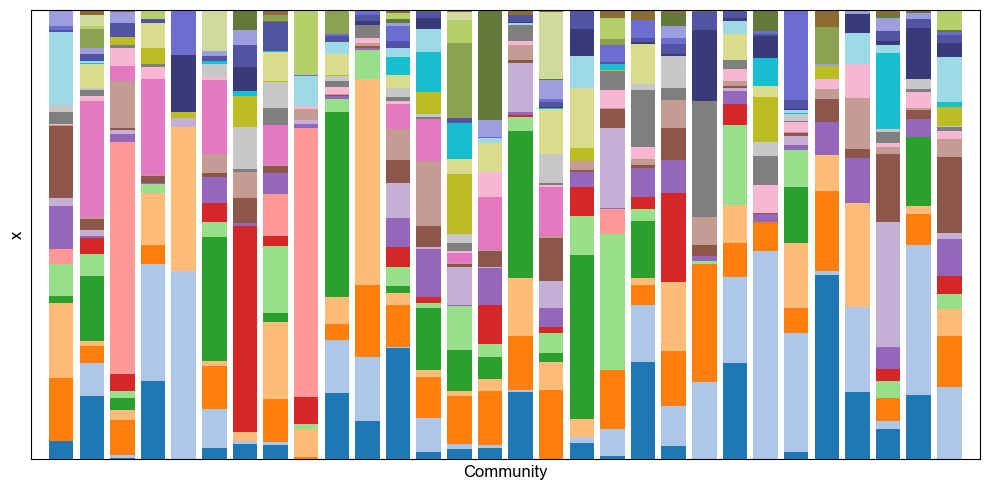

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 data 是一个形状为 (30, 101) 的二维数组
data = xthis

# 归一化数据，使得每列的和为1

# 创建颜色映射对象，包含30种颜色
colors = []
colors.extend(plt.cm.tab20(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20b(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20c(np.linspace(0, 1, 20)))
colors.extend(plt.cm.Set1(np.linspace(0, 1, 9)))
colors.extend(plt.cm.Paired(np.linspace(0, 1, 12)))
colors.extend(plt.cm.Set2(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Accent(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Set3(np.linspace(0, 1, 12)))
colors = colors[:100]
colors.append(([0,0,0,1]))  # 确保总共101种颜色

# 创建堆叠柱状图
fig, ax = plt.subplots()
x = np.arange(30)  # x轴上的点
bottom = np.zeros(30)  # 底部值的初始化

# 绘制堆叠柱状图
for i in range(30):
    ax.bar(x, data[:, i], bottom=bottom, color=colors[i], edgecolor='none')
    bottom += data[:, i]  # 更新底部值，使得下一个柱子在上一个柱子的顶部

# 设置坐标轴和图形属性
ax.set_xlim([-1, 30])
ax.set_ylim([0, 1])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('x', fontsize=12, fontname='Arial')
ax.set_xlabel('Community', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()


In [154]:
mx = np.mean(simulation, axis=1)
n1_orig = (np.array([0.58695652, 0.33423913, 0.45652174, 0.30706522, 0.36684783,
       0.37771739, 0.37771739, 0.69836957, 0.71467391, 0.6548913])*30).astype(int)
dm_origs = np.array([ 0.78799916,  0.49779242,  0.57094609, -0.29606619,  0.64892559,
       -0.47545641, -0.47545641,  0.75077074,  0.71582043,  0.8309626])
N = 30
M = 10
def ConvertToG(G, relabus):
    temp = np.dot(relabus.T, G).T
    return temp / np.sum(temp, axis=0, keepdims=True)

#一种相似度计算方法
def CalculateBC(xthis, ythis):
    return 1 - np.sum(np.minimum(xthis, ythis))

# 计算每列与均值的相似度度量
def CalculateDs(xs):
    mm = xs.shape[1]
    xm = np.mean(xs, axis=1, keepdims=True)
    ds = np.zeros(mm)
    for iii in range(mm):
        ds[iii] = CalculateBC(xs[:, iii], xm.flatten())
    return ds

def shuffle_matrix_rows(matrix):
    # 对矩阵进行复制，防止原矩阵被修改
    shuffled_matrix = np.copy(matrix)
    # 对于矩阵中的每一行进行随机排列
    for row in shuffled_matrix:
        np.random.shuffle(row)
    return shuffled_matrix


def rearrange_rows(matrix):
    """
    Rearranges each row of the matrix while keeping the column sums nearly unchanged.

    Parameters:
    matrix (array): Input 2D array.

    Returns:
    array: Rearranged matrix.
    """
    # Calculate the target column sums
    target_col_sums = np.sum(matrix, axis=0)
    
    # Initialize the rearranged matrix
    rearranged_matrix = np.zeros_like(matrix)
    
    # Iterate over each row
    for i in range(matrix.shape[0]):
        # Get the current row
        row = matrix[i, :]
        
        # Sort the row in ascending order
        sorted_row = np.sort(row)
        
        # Calculate the current column sums
        current_col_sums = np.sum(rearranged_matrix, axis=0)
        
        # Calculate the differences between the target column sums and the current column sums
        col_diff = target_col_sums - current_col_sums
        
        # Rearrange the sorted row elements to minimize the difference with the target column sums
        indices = np.argsort(col_diff)
        rearranged_matrix[i, indices] = sorted_row
    
    return rearranged_matrix

def svd_rearrange(matrix):
    """
    Rearranges the rows of a matrix using SVD and shuffling of the U and V matrices.

    Parameters:
    matrix (array): Input 2D array.

    Returns:
    array: Rearranged matrix.
    """
    # Perform SVD decomposition
    U, Sigma, VT = np.linalg.svd(matrix, full_matrices=False)
    
    # Shuffle rows of U and columns of V
    np.random.shuffle(U)
    np.random.shuffle(VT.T)  # Shuffle the columns of V (or equivalently rows of V^T)
    
    # Reconstruct the matrix
    rearranged_matrix = np.dot(U, np.dot(np.diag(Sigma), VT))
    
    return rearranged_matrix


In [131]:
import numpy as np

def generate_matrix(rows, cols):
    """
    Generates a random 0-1 matrix where the number of 1s in each column
    decreases from left to right and the proportion of 1s is between 0.8 and 0.2.

    Parameters:
    rows (int): Number of rows in the matrix.
    cols (int): Number of columns in the matrix.

    Returns:
    array: A 2D array representing the random 0-1 matrix.
    """
    # Calculate the proportion of 1s for each column
    proportions = np.linspace(0.8, 0.2, cols)
    
    # Initialize the matrix with zeros
    matrix = np.zeros((rows, cols), dtype=int)
    
    for col in range(cols):
        # Determine the number of 1s in this column
        num_ones = int(proportions[col] * rows)
        
        # Generate random indices to place the 1s
        ones_indices = np.random.choice(rows, num_ones, replace=False)
        
        # Set the selected indices to 1
        matrix[ones_indices, col] = 1
    
    return matrix


# Example usage
rows = 30  # Number of rows in the matrix
cols = 10   # Number of columns in the matrix
G_r = generate_matrix(rows, cols)


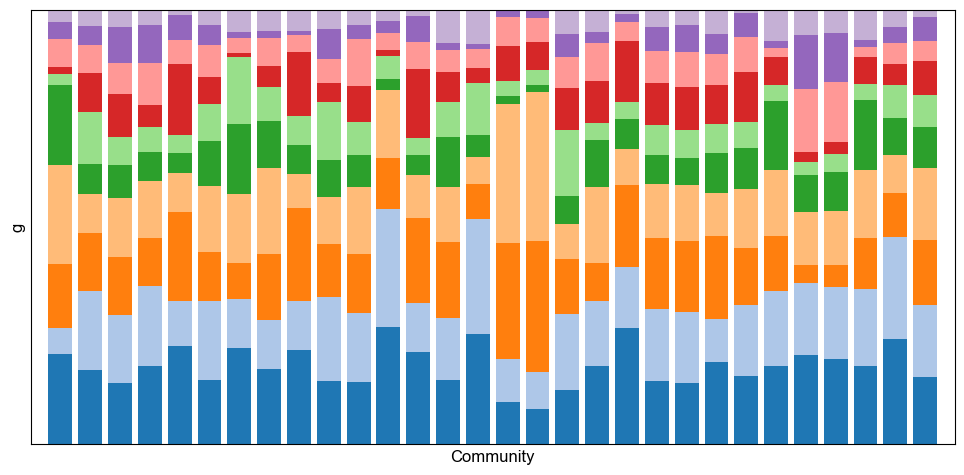

In [132]:
gs = np.dot(relabus.T, G_r).T
# 排序数据并选择绘制部分
gs = gs / np.sum(gs, axis=0, keepdims=True)
sorted_inds_g = np.argsort(np.mean(gs, axis=1))[::-1]
gs = gs[sorted_inds_g][:, :30]

colors = []
colors.extend(plt.cm.tab20(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20b(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20c(np.linspace(0, 1, 20)))
colors.extend(plt.cm.Set1(np.linspace(0, 1, 9)))
colors.extend(plt.cm.Paired(np.linspace(0, 1, 12)))
colors.extend(plt.cm.Set2(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Accent(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Set3(np.linspace(0, 1, 12)))
colors = colors[:100]

# 创建图形和坐标轴
fig, ax = plt.subplots()
ax.set_position([0.1, 0.1, 0.8, 0.8])

# 绘制堆叠柱状图
x = np.arange(30)  # x轴上的点
bottom = np.zeros(30)  # 底部值的初始化
bh = []
for i in range(gs.shape[0]):
    b = ax.bar(x, gs[i], bottom=bottom, color=colors[i], edgecolor='none')
    bh.append(b)
    bottom += gs[i]  # 更新底部值，使得下一个柱子在上一个柱子的顶部

ax.set_xlim([-1, 30])
ax.set_ylim([0, 1])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('g', fontsize=12, fontname='Arial')
ax.set_xlabel('Community', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()

In [155]:
dg_orig = CalculateDs(ConvertToG(G_r, simulation))
dg_m_orig = np.mean(dg_orig)

# 模拟
ns = int(1e4)

dg_m_shfls = np.zeros(ns)
for rep in range(ns):
    # 随机按行打乱矩阵G
    G_shuffled = G_r[np.random.permutation(N), :]
    dg_m_shfls[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, simulation)))


dg_m_shfls_row = np.zeros(ns)
for rep in range(ns):
    # 打乱每一行G的分布
    #G_shuffled = G[np.random.permutation(N), :]
    #G_shuffled = shuffle_matrix_rows(G_r)
    #G_shuffled = rearrange_rows(G_r)
    G_shuffled = svd_rearrange(G_r)
    dg_m_shfls_row[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, simulation)))

#fig, ax = plt.subplots()

dg_m_shfls_col = np.zeros(ns)
for rep in range(ns):
    # 打乱每一列G的分布
    #G_shuffled = G[np.random.permutation(N), :]
    G_shuffled = shuffle_matrix_rows(G_r.T).T
    dg_m_shfls_col[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, simulation)))

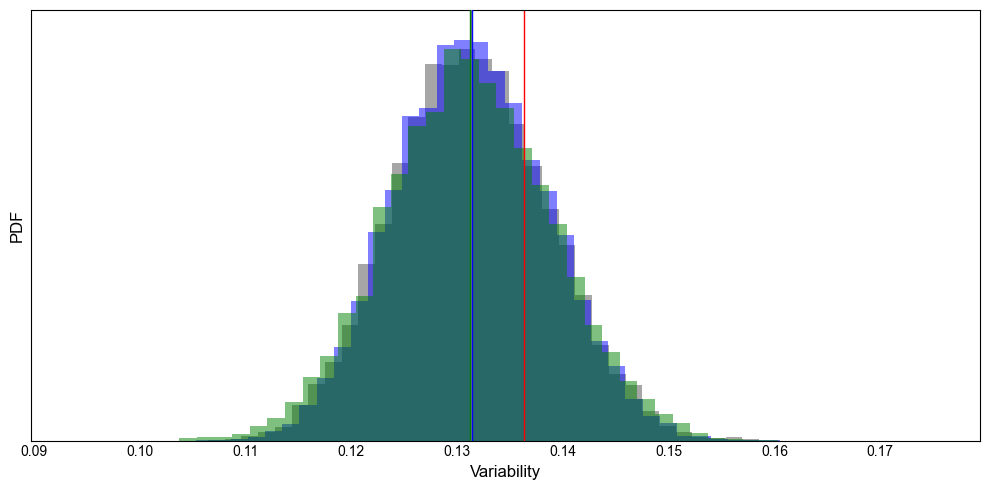

In [156]:
# 可视化
fig, ax = plt.subplots()
dg_m_shfls = dg_m_shfls[~np.isnan(dg_m_shfls)]
xthis = dg_m_shfls
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, edgecolor='none', facecolor='grey',alpha=0.7, zorder=1)

# 添加原始 dg 的直线
ymax = np.max(h[0])
ax.plot([dg_m_orig, dg_m_orig], [0, ymax * 1.1], '-', linewidth=1, color='red')
ax.plot([np.mean(dg_m_shfls), np.mean(dg_m_shfls)], [0, ymax * 1.1], '-', linewidth=1, color='grey', zorder=5)

xthis = dg_m_shfls_row
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, facecolor='blue',alpha=0.5, zorder=1)
ax.plot([np.mean(dg_m_shfls_row), np.mean(dg_m_shfls_row)], [0, ymax * 1.1], '-', linewidth=1, color='blue', zorder=5)

dg_m_shfls_col = dg_m_shfls_col[~np.isnan(dg_m_shfls_col)]
xthis = dg_m_shfls_col
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, facecolor='green',alpha=0.5, zorder=1)
ax.plot([np.mean(dg_m_shfls_col), np.mean(dg_m_shfls_col)], [0, ymax * 1.1], '-', linewidth=1, color='green', zorder=5)

# 设置图形属性
ax.set_ylim([0, ymax * 1.1])
ax.set_yticks([])
#ax.set_xlim([0.025, 0.175])
#ax.set_xticks([0.05, 0.1, 0.15])
ax.set_ylabel('PDF', fontsize=12, fontname='Arial')
ax.set_xlabel('Variability', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()

In [157]:
target_funcom = np.sum(G_r, axis=0) / np.sum(np.sum(G_r, axis=0))
gs_orig = np.dot(simulation.T, G_r).T
# 排序数据并选择绘制部分
gs_orig = gs_orig / np.sum(gs_orig, axis=0, keepdims=True)
ind2keep = np.argsort([CalculateBC(x.T, target_funcom) for x in gs_orig.T])

In [158]:
dg_orig = CalculateDs(ConvertToG(G_r, simulation[:,ind2keep[:20]]))
dg_m_orig = np.mean(dg_orig)

# 模拟
ns = int(1e4)

dg_m_shfls = np.zeros(ns)
for rep in range(ns):
    # 随机按行打乱矩阵G
    G_shuffled = G_r[np.random.permutation(N), :]
    dg_m_shfls[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, simulation[:,ind2keep[:20]])))


dg_m_shfls_row = np.zeros(ns)
for rep in range(ns):
    # 打乱每一行G的分布
    #G_shuffled = G[np.random.permutation(N), :]
    #G_shuffled = shuffle_matrix_rows(G_r)
    #G_shuffled = rearrange_rows(G_r)
    G_shuffled = svd_rearrange(G_r)
    dg_m_shfls_row[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, simulation[:,ind2keep[:20]])))

#fig, ax = plt.subplots()

dg_m_shfls_col = np.zeros(ns)
for rep in range(ns):
    # 打乱每一列G的分布
    #G_shuffled = G[np.random.permutation(N), :]
    G_shuffled = shuffle_matrix_rows(G_r.T).T
    dg_m_shfls_col[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, simulation[:,ind2keep[:20]])))

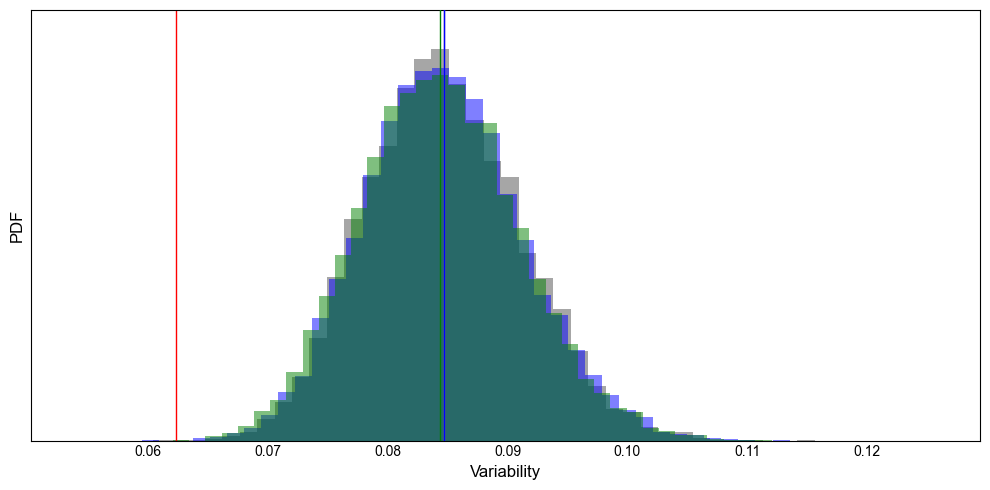

In [159]:
# 可视化
fig, ax = plt.subplots()
dg_m_shfls = dg_m_shfls[~np.isnan(dg_m_shfls)]
xthis = dg_m_shfls
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, edgecolor='none', facecolor='grey',alpha=0.7, zorder=1)

# 添加原始 dg 的直线
ymax = np.max(h[0])
ax.plot([dg_m_orig, dg_m_orig], [0, ymax * 1.1], '-', linewidth=1, color='red')
ax.plot([np.mean(dg_m_shfls), np.mean(dg_m_shfls)], [0, ymax * 1.1], '-', linewidth=1, color='grey', zorder=5)

xthis = dg_m_shfls_row
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, facecolor='blue',alpha=0.5, zorder=1)
ax.plot([np.mean(dg_m_shfls_row), np.mean(dg_m_shfls_row)], [0, ymax * 1.1], '-', linewidth=1, color='blue', zorder=5)

dg_m_shfls_col = dg_m_shfls_col[~np.isnan(dg_m_shfls_col)]
xthis = dg_m_shfls_col
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, facecolor='green',alpha=0.5, zorder=1)
ax.plot([np.mean(dg_m_shfls_col), np.mean(dg_m_shfls_col)], [0, ymax * 1.1], '-', linewidth=1, color='green', zorder=5)

# 设置图形属性
ax.set_ylim([0, ymax * 1.1])
ax.set_yticks([])
#ax.set_xlim([0.025, 0.175])
#ax.set_xticks([0.05, 0.1, 0.15])
ax.set_ylabel('PDF', fontsize=12, fontname='Arial')
ax.set_xlabel('Variability', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()